In [1]:
import numpy as np
from numpy.linalg import cholesky
from numpy.linalg import eigvals
from numpy.linalg import inv

import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [2]:
# defines a block matrix - useful for constructing 4-d correlation matrix 
class block_matrix:
    
    # initialize zero matrix
    def __init__(self, n, m, p, q):
        self.matrix = np.zeros((n*p, m*q))
     
    # set element i, j with matrix a
    def set_element(self, i, j, a):
        p, q = np.shape(a)
        for k in range(p):
            for l in range(q):
                self.matrix[p*i+k, q*j+l] = a[k, l]
    
    # print the matrix nicely
    def __str__(self):
        return_string = ''
        format_string = '{:.2e}'
        m, n = np.shape(self.matrix)
        for i in range(m):
            for j in range(n):
                return_string += format_string.format(self.matrix[i, j]) + ' '
            return_string += '\n'
        return return_string

In [3]:
# defines a gaussian process
class gp:
    
    # initialize with a kernel and mean value (not a function, yet...)
    def __init__(self, mean, kernel1, kernel2=None, wn=1e-6):
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.mean = mean
        self.wn = wn
    
    # generate the covariance matrix in the 1d case
    def _make_covariance_matrix(self, x):
        n = len(x)
        sigma = np.matrix(np.zeros((n, n)))
        for i in range(n):
            for j in range(i+1):
                sigma[i, j] = self.kernel1(x[i] - x[j])
                sigma[j, i] = sigma[i, j]
        return sigma
    
    # generate the covariance matrix in the 2d case. subcov is the covariance matrix for the second dimension. 
    def _make_covariance_matrix_2d(self, x):
        n = len(x)
        p = len(self.kernel2)
        sigma = block_matrix(n, n, p, p)
        cov1d = np.zeros((n, n))
        # define the covariance matrix in the first dimension:
        for i in range(n):
            for j in range(i+1):
                cov1d[i, j] = self.kernel1(x[i]-x[j])
                cov1d[j, i] = cov1d[i, j]
                
        for i in range(p):
            for j in range(i+1):
                if i is j:
                    sigma.set_element(i, j, cov1d*self.kernel2[i, j] + np.diag(self.wn*np.ones(len(cov1d))))
                else:
                    sigma.set_element(i, j, cov1d*self.kernel2[i, j])
                    sigma.set_element(j, i, cov1d*self.kernel2[i, j])
        return sigma.matrix
    
    # sample the gaussian process in 1 or 2 dimensions. 
    def sample(self, x, two_d=False):
        
        if two_d:
            sigma = self._make_covariance_matrix_2d(x)
            n_samples = len(self.kernel2)
            n = n_samples*len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            samp = np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]
            ret = []
            for i in range(n_samples):
                ret.append(samp[i*len(x):(i+1)*len(x)])
            return ret
        else:
            sigma = self._make_covariance_matrix(x)
            n = len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            return np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]

# defines the kernel for the gaussian process
class kernel:
    
    # empty init function
    def __init__(self):
        return
     
    # apparently with zero white noise the covariance matrix may not be positive definite...  
    # square exponential kernel with white noise
    def exp_sq_kernel(l, sig, wn=1e-12): 
        def k(r):
            return (sig**2)*np.exp(-(r**2)/(2*(l**2))) + (r == 0)*wn
        return k
    
    def scale_kernel(scale):
        return np.outer(scale, scale)
    
    # white noise adds sigma to diagonal
    def white_noise_kernel(self, white_noise):
        def k(r):
            if r == 0:
                return white_noise
        return k


In [4]:
# define the kernel function
k1 = kernel.exp_sq_kernel(0.05, 1)
k2 = kernel.scale_kernel([0.004, 0.012, 0.020])
# initialize the gaussian process with kernel function k and mean of 1
g = gp(0, k1, kernel2=k2, wn=1e-5)

# times to sample at
t = np.linspace(0, 1, 500)

# sample the GP
x1, x2, x3 = g.sample(t, two_d=True)

Text(0,0.5,'flux (?) (dependent variable)')

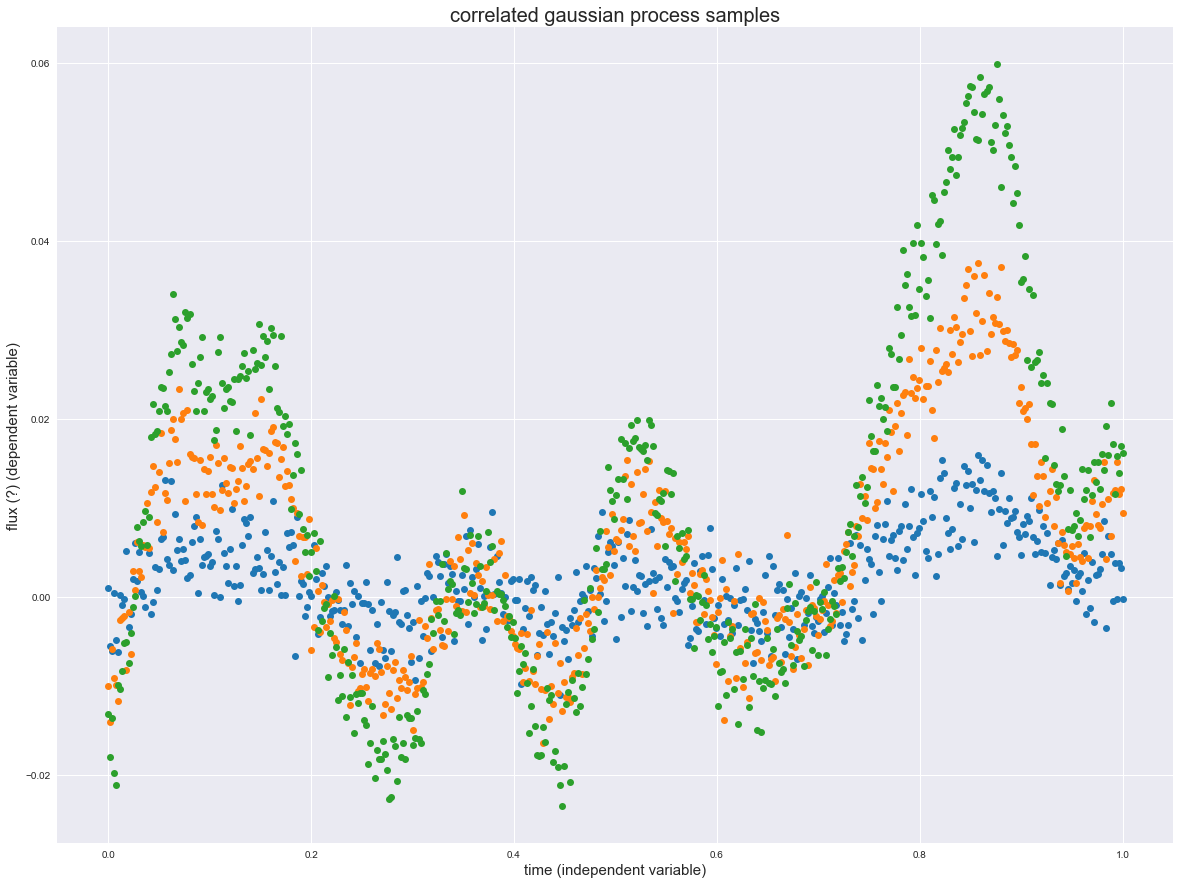

In [5]:
# plot the samples
fig = pl.figure(figsize=(20, 15))
pl.plot(t, x1, 'o', alpha=1, color=palette[0])
pl.plot(t, x2, 'o', alpha=1, color=palette[1])
pl.plot(t, x3, 'o', alpha=1, color=palette[2])

pl.title('correlated gaussian process samples', size=20)
pl.xlabel('time (independent variable)', size=15)
pl.ylabel('flux (?) (dependent variable)', size=15)

In [6]:
import astropy.constants as ac
import batman

def transit_model(params, t):
    p = batman.TransitParams()
    p.t0, p.per, p.rp, p.a, p.inc, p.ecc, p.w, u0, u1 = params
    p.u = [u0, u1]
    p.limb_dark = "quadratic"
    planet = batman.TransitModel(p, t)
    return planet.light_curve(p)

per = 10
t0 = t.min() + (t.max()-t.min())/2. - per
mp_ratio = 0.5
rp = (10*ac.R_earth.value/(ac.R_sun.value))
a = 0.1
a_stellar_rad = a * ac.au.value/(ac.R_sun.value)
inc = 88
ecc = 0
w = 90
u0 = 0.2
u1 = 0.2
planet = transit_model([t0, per, rp, a_stellar_rad, inc, ecc, w, u0, u1], t)

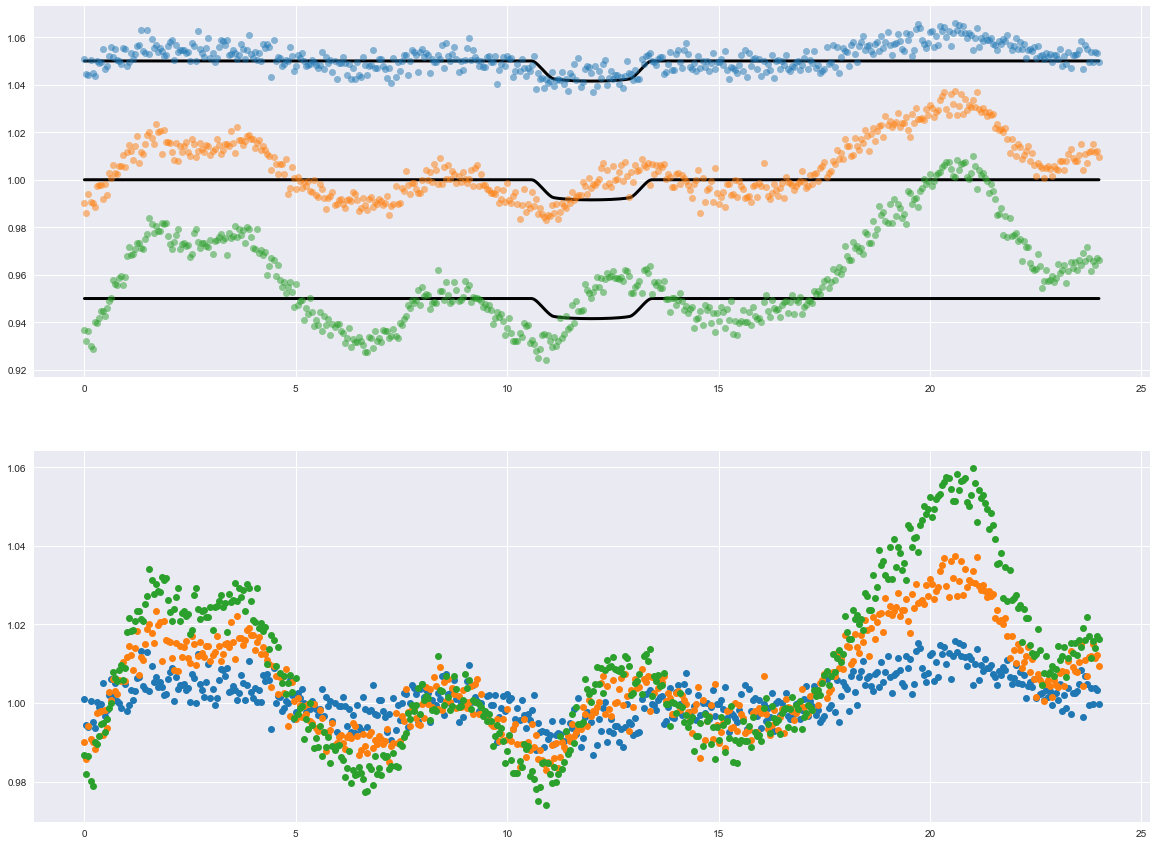

In [7]:
fig, axs = pl.subplots(2, 1, figsize=(20, 15))
hours = t*24

axs[0].plot(hours, planet + 0.05, 'k', linewidth=3)
axs[0].plot(hours, planet, 'k', linewidth=3)
axs[0].plot(hours, planet - 0.05, 'k', linewidth=3)

axs[0].plot(hours, x1 + planet + 0.05, 'o', alpha=0.5, color=palette[0])
axs[0].plot(hours, x2 + planet, 'o', alpha=0.5, color=palette[1])
axs[0].plot(hours, x3 + planet - 0.05, 'o', alpha=0.5, color=palette[2])

axs[1].plot(hours, x1 + planet, 'o', alpha=1, color=palette[0])
axs[1].plot(hours, x2 + planet, 'o', alpha=1, color=palette[1])
axs[1].plot(hours, x3 + planet, 'o', alpha=1, color=palette[2])